# Task 3 - Text Mining

In [1]:
## SETUP
import pandas as pd

df = pd.read_csv('datasets/Movie.csv')

rs = 10 # random state

import warnings
warnings.filterwarnings("ignore")

# average length of Description column
print(df['Description'].apply(lambda x: len(x)).mean() )

761.7859824780976


In [2]:
## DATA PREPROCESSING
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# init lemmatizer and punctuation filter
lemm = WordNetLemmatizer()
punct = set(string.punctuation)

# load provided stopwords
df_stop = pd.read_csv('datasets/Movie.csv')

# join provided stopwords with the default NLTK english stopwords
stopwords = set(df_stop['Description']).union( set(sw.words('english')))

# filter out words
stopwords.add('official');
stopwords.add('site');
stopwords.add('c');
stopwords.add('life');

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ,
    }.get(tag[0], wn.NOUN)
    
    return lemm.lemmatize(token, tag)


In [3]:
# takes a document string, split into tokens and preprocess them
def cab_tokenizer(document):
    tokens = []
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and the create
        # part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            # if stopword, ignore and continue
            if token in stopwords:
                continue
            # if punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
            #Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [4]:
# vectorise/ transform tokens into matrices
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectorizer
tfidf_vec = TfidfVectorizer( tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Description'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print( len(tfidf_vec.get_feature_names() ))

65230


In [5]:
## INITIAL DOCUMENT ANALYSIS
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=5, random_state=rs).fit(X)

In [6]:
# function to visualise text cluster.
def visualise_text_clusters(n_clusters, cluster_centers, terms, num_word = 5):
    # --- Params ---
    # cluster_centers: cluster centers of fitted/trained Kmeans/other centroid-based cluster
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. change as you please
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]    
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_clusters(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: friend, find, best, meet, young, 
Top terms for cluster 1: old, year, family, kid, boy, 
Top terms for cluster 2: love, film, woman, two, story, 
Top terms for cluster 3: world, secret, one, battle, century, 
Top terms for cluster 4: film, war, documentary, footage, song, 


In [7]:
## FEATURE SELECTION AND TRANSFORMATION

import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionally
def calculate_tf_idf_terms(document_col):
    #param - document_col: collection of raw document text that you want to analyze
    from sklearn.feature_extraction.text import CountVectorizer
    
    # use count vecotrizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2) )
    X_count = count_vec.fit_transform( df['Description'] )
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
             'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero() }
            for t in count_vec.vocabulary_]
    return terms

terms = calculate_tf_idf_terms( df['Description'] )

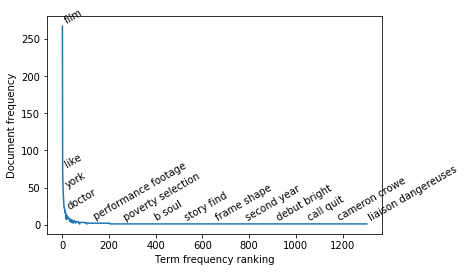

In [8]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
            
    plt.show()
    
visualise_zipf(terms)

In [9]:
## filter out high and low terms

#limit the terms produced to terms that occured in min of 2 documents and max of 80% of all docs
filter_vec = TfidfVectorizer( tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.3)
X_filter = filter_vec.fit_transform( df.Description )

# see the num of unique tokens produced by the vectorizer. Reduced
print( len(filter_vec.get_feature_names() ) )

9819


In [10]:
# build another cluster based on refined features

#K means clustering using the new term vector
kmeans_fil = KMeans( n_clusters=5, random_state=rs).fit(X_filter)

In [11]:
# visualisation
visualise_text_clusters(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names() )

Top terms for cluster 0: young, family, studio, heart, new, 
Top terms for cluster 1: love, year, old, new, story, 
Top terms for cluster 2: friend, find, get, family, save, 
Top terms for cluster 3: documentary, voice, artist, world, one, 
Top terms for cluster 4: alien, one, planet, make, earth, 


In [12]:
# get most frequent terms in start list
n = sorted(terms, key=lambda k: k['tf'], reverse=True)
for i in range(6):
    print(n[i].get('term'), ":", n[i].get('tf'))

film : 425
one : 285
new : 236
find : 225
year : 224
take : 211
